# 에이전트 대화 시뮬레이션(고객 응대 시나리오)

챗봇을 구축할 때, 예를 들어 고객 지원 어시스턴트와 같은 경우, 챗봇의 성능을 제대로 평가하는 것이 어려울 수 있습니다. 코드 변경마다 집중적으로 수동으로 상호 작용하는 것은 시간이 많이 소요됩니다.

평가 과정을 더 쉽고 재현 가능하게 만드는 한 가지 방법은 **사용자 상호 작용을 시뮬레이션하는 것** 입니다.

LangGraph를 사용하면 이를 설정하는 것이 쉽습니다. 

아래는 대화를 시뮬레이션하기 위해 "가상 사용자(Simulated User)"를 생성하는 방법의 예시입니다.

![agent-simulations.png](assets/agent-simulations.png)

## 환경 설정

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [3]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


## 상태(State) 정의

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지

## 상담사, 고객 역할 정의

### 상담사 역할 정의

시뮬레이션에서 **상담사** 역할을 하는 챗봇을 정의합니다.

**참고**

- `call_chatbot` 내의 구현은 설정 가능하며, 내부에서 사용한 모델을 Agent 로 변경하는 것도 가능합니다.
- `call_chatbot` 은 사용자로부터 메시지를 입력으로 받아, 고객을 상담하는 역할을 부여하겠습니다. 

*고객 지원 시나리오에서의 대화 응답 생성에 활용될 수 있습니다.*

In [5]:
from typing import List
from langchain_teddynote.models import LLMs, get_model_name
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.output_parsers import StrOutputParser

# 모델 이름 설정
MODEL_NAME = get_model_name(LLMs.GPT4)


def call_chatbot(messages: List[BaseMessage]) -> dict:
    # LangChain ChatOpenAI 모델을 Agent 로 변경할 수 있습니다.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})

`call_chatbot` 은 사용자의 입력을 받아 챗봇의 응답을 처리합니다. 

In [6]:
call_chatbot([("user", "안녕하세요?")])

'안녕하세요! 어떻게 도와드릴까요?'

### 고객 역할(Simulated User) 정의

이제 시뮬레이션된 고객의 역할을 정의합니다. 고객 지원 시나리오에서의 대화를 시뮬레이션합니다. 

시스템 프롬프트는 고객과 고객 지원 담당자 간의 상호작용을 설정하며, 사용자 지시사항을 통해 시나리오의 세부 사항을 제공합니다. 

이 구성은 특정 사용자 요구(예: 환불 요청)에 대한 모델의 반응을 시뮬레이션하는 데 사용됩니다.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


def create_scenario(name: str, instructions: str):
    # 시스템 프롬프트를 정의: 필요에 따라 변경
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""

    # 대화 메시지와 시스템 프롬프트를 결합하여 채팅 프롬프트 템플릿을 생성합니다.
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # 특정 사용자 이름과 지시사항을 사용하여 프롬프트를 부분적으로 채웁니다.
    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt

가상의 시나리오를 생성합니다. 이 가상의 시나리오는 고객의 입장에서의 시나리오입니다.

여기서는 환불을 요청하는 시나리오를 정의합니다.


In [8]:
# 사용자 지시사항을 정의합니다.
instructions = """You are tyring to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

# 사용자 이름을 정의합니다.
name = "Teddy"

create_scenario(name, instructions).pretty_print()

================================ System Message ================================

You are a customer of an airline company. You are interacting with a user who is a customer support person. 
Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean.

============================= Messages Placeholder =============================

{messages}


In [9]:
# OpenAI 챗봇 모델을 초기화합니다.
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)

# 시뮬레이션된 사용자 대화를 생성합니다.
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()

생성된 `simulated_user` 를 호출하여 시뮬레이션된 사용자에게 메시지를 전달합니다.

In [10]:
from langchain_core.messages import HumanMessage

# 시뮬레이션된 사용자에게 메시지를 전달
messages = [HumanMessage(content="안녕하세요? 어떻게 도와 드릴까요?")]
simulated_user.invoke({"messages": messages})

'안녕하세요. 저는 작년에 제주도로 여행을 갔었는데, 그 여행에 대한 환불을 요청하고 싶습니다. 모든 돈을 돌려받고 싶습니다. 도와주실 수 있나요?'

## 에이전트 시뮬레이션 정의하기

아래의 코드는 시뮬레이션을 실행하기 위한 LangGraph 워크플로우를 생성합니다. 

주요 구성 요소는 다음과 같습니다:

1. 시뮬레이션된 사용자와 챗봇을 위한 두 개의 노드입니다.
2. 조건부 정지 기준을 가진 그래프 자체입니다.

### 노드 정의

먼저, 그래프에서 노드를 정의합니다. 이들은 메시지 목록을 입력으로 받아 상태에 추가할 메시지 목록을 반환해야 합니다.
이것들은 위에 있는 챗봇과 시뮬레이션된 사용자를 둘러싼 것 래퍼들입니다.

**참고:** 여기서 까다로운 점은 어떤 메시지가 어떤 것인지 구분하는 것입니다. 

챗봇과 시뮬레이션된 사용자 모두 LLMs이기 때문에, 둘 다 AI 메시지로 응답할 것입니다. 우리의 상태는 인간과 AI 메시지가 번갈아 가며 나열된 목록이 될 것입니다. 이는 노드 중 하나에서 AI와 인간 역할을 바꾸는 논리가 필요함을 의미합니다. 

이 예제에서는, HumanMessages가 시뮬레이션된 사용자로부터 온 메시지라고 가정할 것입니다. 이는 시뮬레이션된 사용자 노드에 AI와 Human 메시지를 교환하는 논리가 필요함을 의미합니다.

In [11]:
from langchain_core.messages import AIMessage


# 상담사 역할
def ai_assistant_node(messages):
    # 상담사 응답 호출
    ai_response = call_chatbot(messages)

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}

상담사 역할의 노드를 호출합니다.

In [12]:
ai_assistant_node(
    [
        ("user", "안녕하세요?"),
        ("assistant", "안녕하세요! 어떻게 도와드릴까요?"),
        ("user", "환불 어떻게 하나요?"),
    ]
)

{'messages': [('assistant',
   '환불 절차는 다음과 같습니다:\n\n1. **예약 확인**: 예약 번호와 성함을 준비해 주세요.\n2. **고객센터 연락**: 저희 고객센터에 전화하시거나 웹사이트의 고객 지원 페이지를 통해 문의해 주세요.\n3. **환불 요청 제출**: 환불 요청서를 작성하여 제출하셔야 합니다. 필요한 경우, 이메일이나 온라인 양식을 통해 요청하실 수 있습니다.\n4. **환불 처리**: 요청이 접수되면, 환불 절차가 진행됩니다. 환불 처리 기간은 일반적으로 7-14일 정도 소요될 수 있습니다.\n\n추가적인 질문이 있으시면 언제든지 말씀해 주세요!')]}

다음으로, 우리의 시뮬레이션된 사용자를 위한 노드를 정의해 보겠습니다.

**참고**

- 이 과정에서는 메시지의 역할을 교체하는 작은 로직이 포함될 것입니다.

In [13]:
def _swap_roles(messages):
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage 로 변환합니다.
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage 로 변환합니다.
            new_messages.append(AIMessage(content=m.content))
    return new_messages


# 상담사 역할(AI Assistant) 노드 정의
def ai_assistant_node(state: State):
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


# 시뮬레이션된 사용자(Simulated User) 노드 정의
def simulated_user_node(state: State):
    # 메시지 타입을 교환: AI -> Human, Human -> AI
    new_messages = _swap_roles(state["messages"])

    # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}

### 엣지 정의

이제 엣지에 대한 로직을 정의할 필요가 있습니다. 주된 로직은 시뮬레이션된 사용자가 작업을 마친 후 발생하며, 두 가지 결과 중 하나로 이어져야 합니다:

- 고객 지원 봇을 호출하여 계속 진행("continue")
- 대화를 마치고 종료("end")

그렇다면 대화가 종료되는 로직은 무엇일까요? 우리는 이를 인간 챗봇이 `FINISHED`로 응답하거나(시스템 프롬프트 참조) 대화가 6개 메시지를 초과하는 경우로 정의할 것입니다 (이는 이 예제를 짧게 유지하기 위한 임의의 숫자입니다).

`should_continue` 함수는 메시지 리스트를 인자로 받아, 리스트의 길이가 6을 초과하거나 마지막 메시지의 내용이 'FINISHED'일 경우 'end'를 반환합니다. 

그렇지 않으면 'continue'를 반환하여 처리를 계속하도록 합니다.

In [14]:
def should_continue(state: State):
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환합니다.
    if len(state["messages"]) > 6:
        return "end"
    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환합니다.
    elif state["messages"][-1].content == "FINISHED":
        return "end"
    # 위의 조건에 해당하지 않으면 'continue'를 반환합니다.
    else:
        return "continue"

## 그래프 정의

이제 시뮬레이션을 설정하는 그래프를 정의합니다.

`MessageGraph` 클래스는 챗봇과 시뮬레이션된 사용자 간의 상호작용을 구성하고 시뮬레이션하는 데 사용됩니다. 

In [15]:
from langgraph.graph import END, StateGraph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()

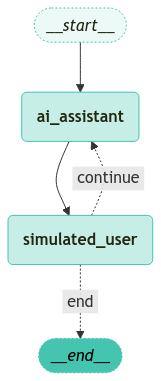

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(simulation)

## 시뮬레이션 시작

이제 우리의 챗봇을 평가할 수 있습니다! 빈 메시지로 호출할 수 있습니다(이것은 챗봇이 초기 대화를 시작하게 하는 것을 시뮬레이션합니다)



시뮬레이션에서 스트리밍되는 데이터 청크를 순회하며, 최종 종료 청크(`END`)를 제외한 모든 이벤트를 출력합니다. 

In [20]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid


# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}

# 그래프 스트리밍
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요! 불편을 드려서 정말 죄송합니다. 어떤 문제로 화가 나셨는지 말씀해 주시면, 최선을 다해 도와드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
작년 제주도 여행에 대한 환불을 요청하고 싶습니다. 모든 돈을 전액 돌려받고 싶어요.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
환불 요청에 대해 말씀해 주셔서 감사합니다. 작년 제주도 여행에 대한 환불은 예약하신 항공권의 종류와 취소 정책에 따라 다를 수 있습니다. 예약 번호와 함께 어떤 사유로 환불을 원하시는지 알려주시면, 더 정확한 정보를 제공해 드릴 수 있습니다. 추가로 필요한 서류나 절차도 안내해 드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호는 12345678입니다. 여행 중에 문제가 발생해서 환불을 원합니다. 모든 비용을 환불해 주셨으면 좋겠어요.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
예약 번호 12345678로 확인해 보겠습니다. 여행 중 발생한 문제에 대해 정말 안타깝게 생각합니다. 환불 요청은 예약하신 항공권의 취소 정책에 따라 다르게 처리될 수 있습니다.

환불 절차를 진행하기 위해서는 몇 가지 정보가 필요합니다:

1. 여행 중 발생한 문제에 대한 구체적인 내용
2. 원하시는 환불 방식 (전액 환불을 원하시는 경우, 사유를 명확히 해주시면 도움이 됩니다)

이 정보를 제공해 주시면, 신속하게 처리할 수 있도록 도와드리겠습니다. 감사합니다.
🔄 Node: simulat